<a href="https://colab.research.google.com/github/saktiworkstation/GNNs-LLMs-Research/blob/main/GNN_DOVE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.6 MB/s eta 0:00:00


In [3]:
import pandas as pd

# Load the uploaded file to examine its structure
file_path = '/content/all-pairwise-interactions.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()

,PDB Code,Title,Complex Type,Biounit chain name (1),Model number (1),Chain Content (1),Biounit chain name (2),Model number (2),Chain Content (2),Mean area buried by each chain,Release Date
0,10gs,"'HUMAN GLUTATHIONE S-TRANSFERASE P1-1, COMPLEX...",HOMO,A,1,PeptideL,B,1,PeptideL,1202.7192,1998-09-16
1,121p,'STRUKTUR UND GUANOSINTRIPHOSPHAT-HYDROLYSEMEC...,HOMO,A,1,PeptideL,A-2,1,PeptideL,768.1447,1994-01-31
2,13gs,'GLUTATHIONE S-TRANSFERASE COMPLEXED WITH SULF...,HOMO,A,1,PeptideL,B,1,PeptideL,1246.4320,1999-01-13
3,15c8,"'CATALYTIC ANTIBODY 5C8, FREE FAB'",HETERO,H,1,PeptideL,L,1,PeptideL,1730.7234,1999-03-23
4,17gs,'GLUTATHIONE S-TRANSFERASE P1-1',HOMO,A,1,PeptideL,B,1,PeptideL,1258.0095,1998-12-30


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462703 entries, 0 to 462702
Data columns (total 11 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   PDB Code                        462703 non-null  object 
 1   Title                           462703 non-null  object 
 2   Complex Type                    462703 non-null  object 
 3   Biounit chain name (1)          462660 non-null  object 
 4   Model number (1)                462703 non-null  int64  
 5   Chain Content (1)               462703 non-null  object 
 6   Biounit chain name (2)          462646 non-null  object 
 7   Model number (2)                462703 non-null  int64  
 8   Chain Content (2)               462703 non-null  object 
 9   Mean area buried by each chain  462703 non-null  float64
 10  Release Date                    462703 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 38.8+ MB


In [6]:
data.describe()

,Model number (1),Model number (2),Mean area buried by each chain
count,462703.0,462703.0,4.627030e+05
mean,1.0,1.0,9.409008e+02
std,0.0,0.0,1.078812e+03
min,1.0,1.0,1.675434e-17
25%,1.0,1.0,2.448993e+02
50%,1.0,1.0,6.096633e+02
75%,1.0,1.0,1.301639e+03
max,1.0,1.0,7.664271e+04


In [12]:
import networkx as nx

# Extract pairs of interacting chains
edges = data[['Biounit chain name (1)', 'Biounit chain name (2)']].values

# Create a graph using NetworkX
protein_graph = nx.Graph()
protein_graph.add_edges_from(edges)

# Add node features (mean area buried) from the dataset
for _, row in data.iterrows():
    chain_1 = row['Biounit chain name (1)']
    chain_2 = row['Biounit chain name (2)']
    mean_area = row['Mean area buried by each chain']

    # Add attributes to nodes
    protein_graph.nodes[chain_1]['mean_area_buried'] = mean_area
    protein_graph.nodes[chain_2]['mean_area_buried'] = mean_area

# Display basic graph information
print(protein_graph)

Graph with 2337 nodes and 22257 edges


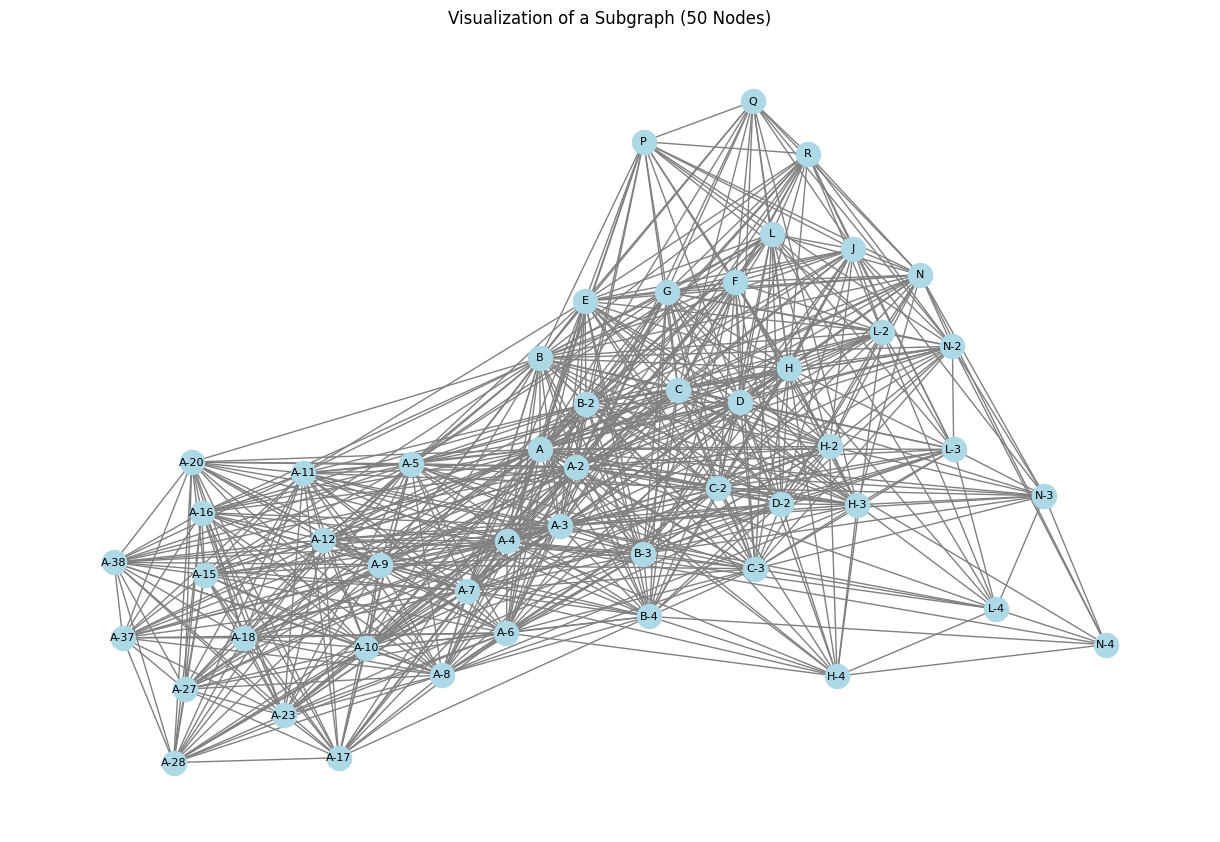

In [13]:
import matplotlib.pyplot as plt

# Visualize a subgraph (sampling a smaller portion for clarity)
subgraph = protein_graph.subgraph(list(protein_graph.nodes)[:50])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)  # Spring layout for better visualization
nx.draw(
    subgraph, pos,
    with_labels=True,
    node_size=300,
    node_color="lightblue",
    font_size=8,
    edge_color="gray"
)
plt.title("Visualization of a Subgraph (50 Nodes)")
plt.show()

In [17]:
from sklearn.preprocessing import MinMaxScaler
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

# Scale the node features (mean_area_buried) for GNN
scaler = MinMaxScaler()
mean_areas = [
    protein_graph.nodes[node].get('mean_area_buried', 0)
    for node in protein_graph.nodes
]
scaled_features = scaler.fit_transform([[value] for value in mean_areas])

# Assign scaled features back to nodes
for idx, node in enumerate(protein_graph.nodes):
    protein_graph.nodes[node]['feature'] = scaled_features[idx][0]

# Convert NetworkX graph to PyTorch Geometric Data format
gnn_data = from_networkx(protein_graph, group_node_attrs=['feature'])

# Check the resulting graph data structure
gnn_data

Data(edge_index=[2, 44514], mean_area_buried=[2337], x=[2337, 1])

In [18]:
# Reloading and adjusting to ensure CPU compatibility in PyTorch Geometric
import torch
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

# Convert the graph to PyTorch Geometric Data object, ensuring compatibility with CPU
gnn_data = from_networkx(protein_graph, group_node_attrs=['feature'])

# Ensure data object is successfully converted
gnn_data

Data(edge_index=[2, 44514], mean_area_buried=[2337], x=[2337, 1])